In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [2]:
dataset = pd.read_csv("datasets/BTC-USD_prices.csv",parse_dates=['formatted_date'], index_col='formatted_date')
dataset.head()

BTC-USD
formatted_date              
2018-01-01      13657.200195
2018-01-02      14982.099609
2018-01-03      15201.000000
2018-01-04      15599.200195
2018-01-05      17429.500000

# EDA

Text(0.5, 1.0, 'BTC price')

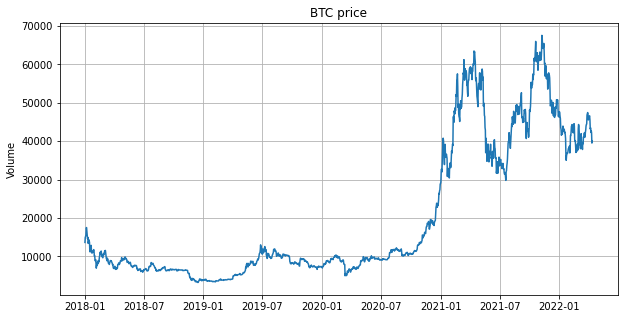

In [3]:
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.ylabel('Volume')
plt.grid()
plt.title("BTC price")

In [4]:
ma_day = [10, 20, 30]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    dataset[column_name] = None
    dataset[column_name] = dataset['BTC-USD'].rolling(ma).mean()

Text(0.5, 1.0, 'BTC-USD')

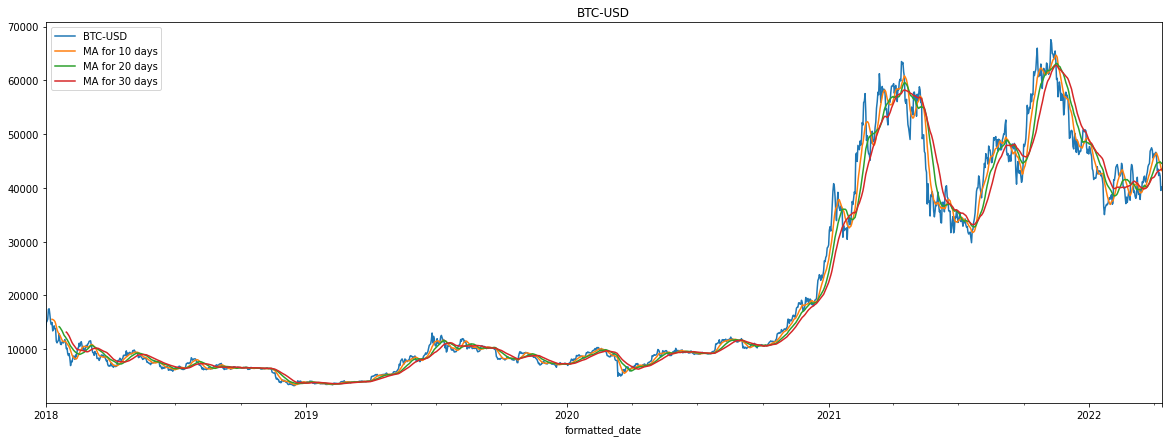

In [5]:
dataset.plot(figsize=(20,7)).set_title('BTC-USD')

In [6]:
dataset['BTC-USD'].describe()

count     1563.000000
mean     19889.652131
std      18119.286698
min       3236.761719
25%       7272.250732
50%       9757.970703
75%      36669.626953
max      67566.828125
Name: BTC-USD, dtype: float64

# Preprocessing

In [7]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
training_data_len

1407

In [8]:
train_df = dataset[['BTC-USD']].iloc[:training_data_len].values
test_df = dataset[['BTC-USD']].iloc[training_data_len:].values

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_df)

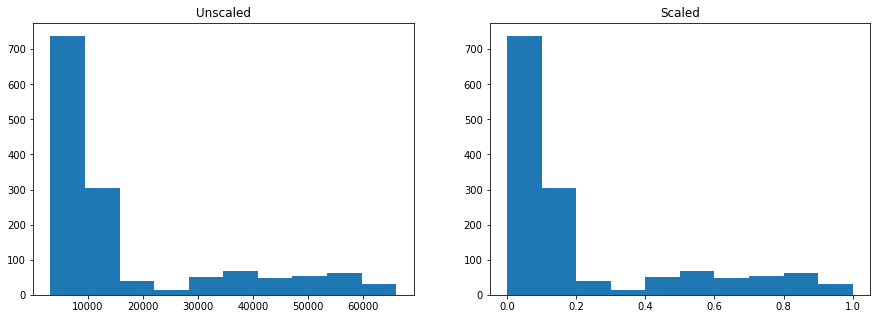

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(15)

axes[0].hist(train_df)
axes[0].set_title('Unscaled')
axes[1].hist(scaled_train)
axes[1].set_title('Scaled')

plt.show()

In [11]:
scaled_test = scaler.transform(test_df)

In [12]:
WINDOW_LEN = 10

x_train = []
y_train = []
for i in range(WINDOW_LEN, len(scaled_train)):
    x_train.append(scaled_train[i-WINDOW_LEN:i, 0])
    y_train.append(scaled_train[i, 0])
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [13]:
x_test = []
y_test = []
for i in range(WINDOW_LEN, len(scaled_test)):
    x_test.append(scaled_test[i-WINDOW_LEN:i, 0])
    y_test.append(scaled_test[i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Baseline

In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10


2022-04-14 13:28:08.438164: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


140/140 [==============================] - 2s 5ms/step - loss: 0.0054
Epoch 2/10
140/140 [==============================] - 1s 5ms/step - loss: 0.0021
Epoch 3/10
140/140 [==============================] - 1s 5ms/step - loss: 9.1804e-04
Epoch 4/10
140/140 [==============================] - 1s 5ms/step - loss: 9.0452e-04
Epoch 5/10
140/140 [==============================] - 1s 5ms/step - loss: 9.4573e-04
Epoch 6/10
140/140 [==============================] - 1s 5ms/step - loss: 6.9369e-04
Epoch 7/10
140/140 [==============================] - 1s 5ms/step - loss: 7.5423e-04
Epoch 8/10
140/140 [==============================] - 1s 5ms/step - loss: 5.8762e-04
Epoch 9/10
140/140 [==============================] - 1s 5ms/step - loss: 6.0785e-04
Epoch 10/10
140/140 [==============================] - 1s 5ms/step - loss: 4.8209e-04


In [15]:
# Get the models predicted price values 
predictions_scaled = model.predict(x_test)
predictions = scaler.inverse_transform(predictions_scaled)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions_scaled - y_test) ** 2)))
rmse

0.12961497732049282

In [16]:
len(y_test),predictions_scaled.shape

(146, (146, 1))

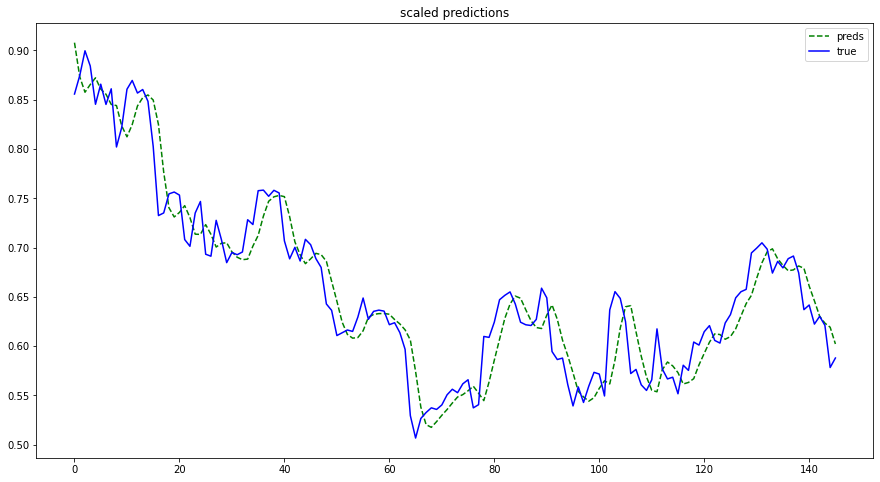

In [17]:
plt.figure(figsize=(15,8))
plt.plot(predictions_scaled,label='preds',color='green',  linestyle='dashed',)
plt.plot(y_test,label='true',color='blue')
plt.legend()
plt.title('scaled predictions')
plt.show()

In [18]:
r2_score(y_test, predictions_scaled )

0.9017016987133477

In [19]:
len_nan = test_df.shape[0] - predictions.shape[0]
print(len_nan)

10


In [20]:
predictions_full = np.append([None]*len_nan,predictions)

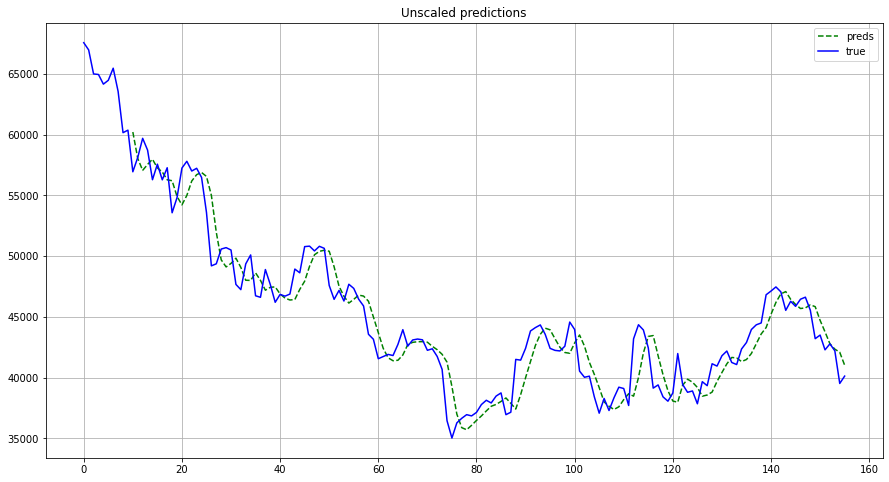

In [21]:
plt.figure(figsize=(15,8))
plt.plot(predictions_full,label='preds',color='green',  linestyle='dashed',)
plt.plot(test_df,label='true',color='blue')
plt.legend()
plt.title('Unscaled predictions')
plt.grid()
plt.show()